# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

Next things to try:

...

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.74:58608 Dashboard: http://10.148.1.74:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [3]:
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
root_path = '/home1/scratch/aponte/'
#root_path = '/home/c11-data/Test_aponte/fsturb/'
run = 'fsturb_m0_4km_0a1000j/'

r = pp.Run(root_path+run, open_nc=['surf'],verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home1/scratch/aponte/fsturb_m0_4km_0a1000j/
Found 10 segments
Found 10 grid files
Found 20 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


---

## utils

In [4]:
def plot_Fy(r, ax=None, scale=1, ls='--', color='k', **kwargs):
    p = r.params_output
    ymid = p['fst_ymid']*scale
    ywid = p['fst_ywid']*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

---

## bulk statistics

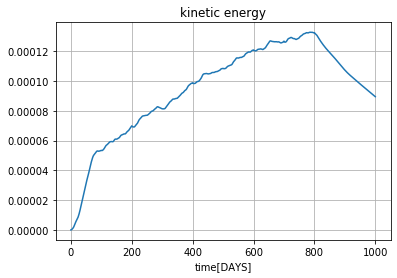

In [5]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()

In [6]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

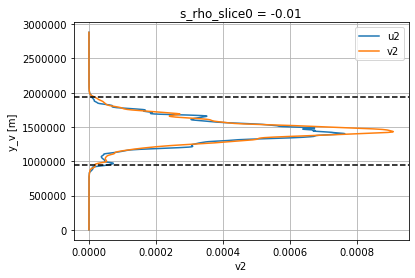

In [7]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()
plot_Fy(r)

In [8]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

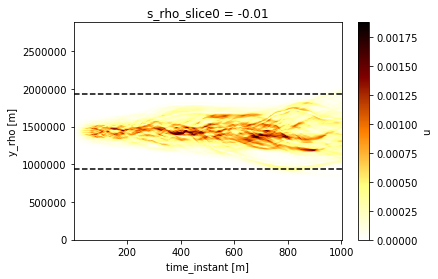

In [9]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape
plot_Fy(r)

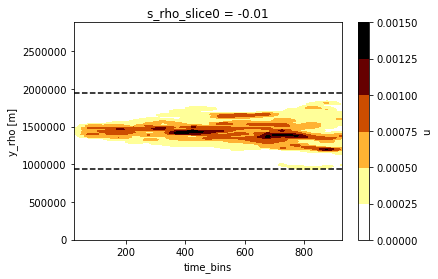

In [10]:
toplt = u2_meanx.groupby_bins('time',np.arange(0,1000,50)).mean('time').squeeze()
toplt.time_bins.values = [t.values.item().mid for t in toplt.time_bins] # contourf won't work otherwise
toplt.plot.contourf(x='time_bins', y='y_rho', cmap='afmhot_r')
plot_Fy(r)

--- 

## pictures

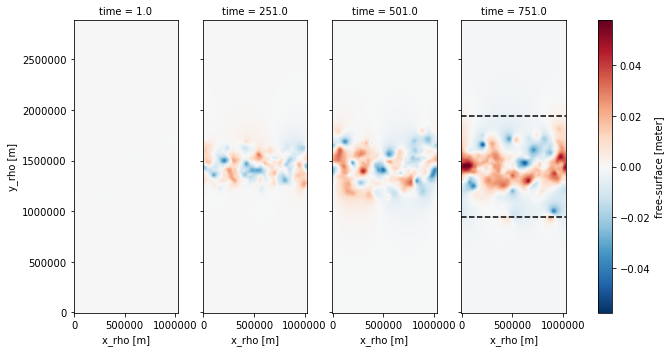

In [11]:
hdl = (r['surf']['ssh'].sel(time=slice(0,1000,250))
         .plot(x='x_rho', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(r, ax=hdl.axes[0,-1])

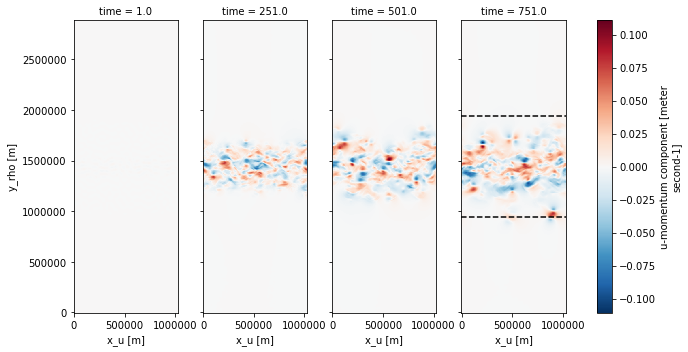

In [12]:
hdl = (r['surf']['u'].sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(r, ax=hdl.axes[0,-1])

In [13]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

AttributeError: 'Grid' object has no attribute '_metrics'

In [14]:
# hardcode derivative: not ideal
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.diff(u, 'eta') + r.xgrid.diff(v, 'xi'))/4e3

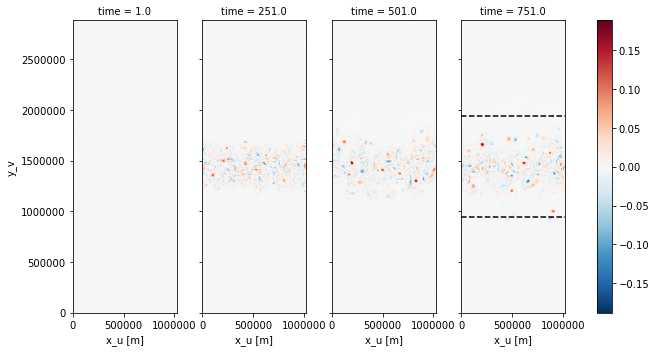

In [15]:
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
hdl = ((zeta/f_zeta).sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_v', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(r, ax=hdl.axes[0,-1])

---

## wavenumber spectra with xrft

In [63]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [64]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()
ekehat

<xarray.DataArray (freq_y_rho: 722, freq_x_rho: 258)>
array([[1.24917578e-06, 9.38100467e-06, 3.99143578e-05, ...,
        5.70306200e-05, 3.99143578e-05, 9.38100467e-06],
       [2.31427663e-06, 1.10488491e-05, 4.89611631e-05, ...,
        7.40274000e-05, 4.30590993e-05, 1.26510079e-05],
       [5.33322956e-06, 1.67634520e-05, 7.27216290e-05, ...,
        8.70061753e-05, 5.26841310e-05, 2.12369225e-05],
       ...,
       [1.07747997e-05, 3.41212593e-05, 6.44013025e-05, ...,
        8.72900763e-05, 1.07226894e-04, 2.62308047e-05],
       [5.33322956e-06, 2.12369225e-05, 5.26841310e-05, ...,
        5.77693052e-05, 7.27216290e-05, 1.67634520e-05],
       [2.31427663e-06, 1.26510079e-05, 4.30590993e-05, ...,
        4.80959981e-05, 4.89611631e-05, 1.10488491e-05]])
Coordinates:
  * freq_y_rho          (freq_y_rho) float64 -0.000125 -0.0001247 ... 0.0001247
  * freq_x_rho          (freq_x_rho) float64 -0.000125 -0.000124 ... 0.000124
    freq_x_rho_spacing  float64 9.69e-07
    freq_y_rho_spacing  float64 3.463e-07

In [65]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [km]')

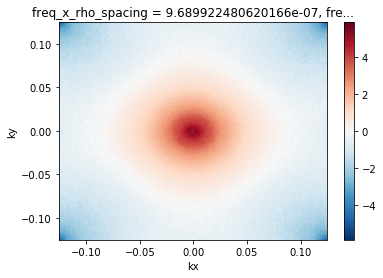

In [66]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [67]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

In [68]:
def add_slope(kmin, kmax, y0, s):
    if isinstance(s, list):
        [add_slope(kmin, kmax, y0, ls) for ls in s]
    else:
        k = np.arange(kmin,kmax,(kmax-kmin)/3.)
        y = y0*(k/k[0])**s
        plt.plot(k, y, 'k')
        plt.text(k[-1], y[-1], ' {i}'.format(i=s))

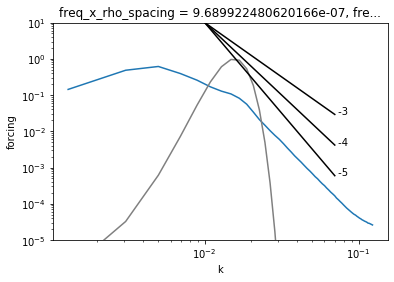

In [75]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

# get forcing wavenumbers
F_k = 1e3*r.params_output['fst_k']
F_dk = 1e3*r.params_output['fst_dk']
F = np.exp(-((ekehat_iso.k-F_k)/F_dk)**2).rename('forcing')

F.plot(x='k', xscale='log', yscale='log', 
                           ylim=(1e-5, 1e1), color='0.5')

add_slope(1e-2, 1e-1, 1e1, [-3, -4, -5])

In [76]:
u = r['surf']['u'].sel(time=slice(50,1000,100))
v = r['surf']['v'].sel(time=slice(50,1000,100))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2)

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

In [77]:
def get_cmap_colors(Nc, cmap='plasma'):
    
    import matplotlib.colors as colors
    import matplotlib.cm as cmx

    scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Nc),
                                   cmap=cmap)
    return [scalarMap.to_rgba(i) for i in range(Nc)]

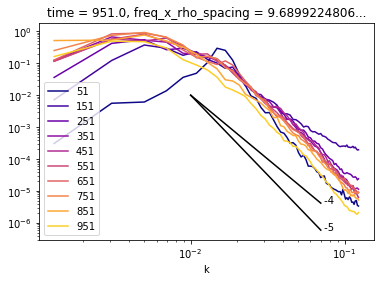

In [78]:
#hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')

colors = get_cmap_colors(ekehat_iso.time.size)

for t, c in zip(ekehat_iso.time, colors):
    ekehat_iso.sel(time=t).plot(x='k', color=c,
                                xscale='log', yscale='log',
                                label='{t}'.format(t=int(t)))
plt.legend()
add_slope(1e-2, 1e-1, 1e-2, [-4,-5])

In [25]:
r.params_output

{'jet_ywidth': 800000.0,
 'jet_weight': 0.0,
 'tdiag_omega': 0.0001454441043,
 'depth': 4000.0,
 'f0': 0.00010313,
 'beta': 0.0,
 'yrbeta': 1440000.0,
 'fst_dt': 864000.0,
 'fst_tdecay': 69120000.0,
 'fst_Nmode': 5.0,
 'fst_a': array([1., 0., 0., 0., 0.]),
 'fst_xmid': 512000.0,
 'fst_xwid': 200000.0,
 'fst_ymid': 1440000.0,
 'fst_ywid': 500000.0,
 'fst_FT': 0.01,
 'fst_k': 1.5625e-05,
 'fst_dk': 3.90625e-06}

---

## make movies

In [100]:
import os
from dask import delayed
import threading

# could delete all figures beforehand
figdir = '/home1/scratch/aponte/figs/'
print('Figures directory: '+figdir)

def genfig(i, ds, v, overwrite=True, figsize=(4,5), ylim=None, **kwargs):
    
    figname = figdir+'%s_t%05d' %(v, i)+'.png'
            
    plt_kw = {'cmap': 'RdGy_r', 'extend':'both'}
    plt_kw.update(kwargs)
    
    xc = next((x for x in ds.dims if x[0]=='x'), False)
    yc = next((x for x in ds.dims if x[0]=='y'), False)
    _ds = ds[v].assign_coords(x=ds[xc]/1e3, y=ds[yc]/1e3)
    xlim = (_ds.x.min(),_ds.x.max())
    if ylim is None:
        ylim = (_ds.y.min(),_ds.y.max())
    
    if not os.path.isfile(figname) or overwrite:
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            d = int(_ds.time)
            h = (_ds.time-d)*24
            title = 'day = %d / h = %.2f hour '%(d, h)
            #
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(1,1,1)
            _ds.plot(x='x',y='y', ax=ax, **plt_kw)
            plot_Fy(r, ax=ax)
            ax.set_aspect('equal', 'box')
            ax.set(xlim=xlim, ylim=ylim)
            ax.set_title(title)
            fig.savefig(figname, bbox_inches = 'tight')
            plt.close()
            #
            m = 1.
    else:
        m = -1.
    return m

Figures directory: /home1/scratch/aponte/figs/


In [101]:
def spawn_computations(ds, plt_kw, Nt=None):
    if Nt is None:
        Nt = ds.time.size
    rg = range(0,Nt)
    II = np.array_split(rg,len(rg)/(28*2))
    print('%d loops to be done'%len(II))
    for I in II:
        print('  %d - %d'%(I[0],I[-1]))
        values = [delayed(genfig)(i, ds.isel(time=i), v, **plt_kw) for i in I]
        futures = client.compute(values)
        results = client.gather(futures)

In [103]:
v = 'zeta'
_ds = (zeta/f_zeta).rename('zeta').isel(time=slice(0,None,1)).to_dataset()
plt_kw = {'vmin': -.2, 'vmax': .2}
spawn_computations(_ds, plt_kw)

17 loops to be done
  0 - 58
  59 - 117
  118 - 176
  177 - 235
  236 - 294
  295 - 353
  354 - 412
  413 - 471
  472 - 530
  531 - 589
  590 - 648
  649 - 707
  708 - 766
  767 - 825
  826 - 883
  884 - 941
  942 - 999


---

In [ ]:
cluster.close()